In [39]:
import numpy as np

import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
%pylab inline

SMALL_SIZE = 25
MEDIUM_SIZE = SMALL_SIZE+2
BIGGER_SIZE = MEDIUM_SIZE +2

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

Populating the interactive namespace from numpy and matplotlib


In [40]:
# Constants
D_rho = 2.2e-5  # kg/ms
R = 8.314  # J/K*mol
dM = 0.003  # kg/mol
M = 0.352  # kg/mol of UF6
M_atm = 0.238  # atomic mass of natural uranium

# Centrifuge assumptions
x = 1000  # pressure ratio (Glaser)
k = 2.0  # L/F ratio

# Centrifuge parameters
# v_a = 485.0 # m/s
# Z = 1.0   # m
# d = 0.15  # m
# F_m = 15e-6 # kg/s (paper is in mg/s)
#r_12 = 0.746


def calc_del_U(cut):
    
    Z = 0.5
    d = 0.15
    v_a = 485.0
    F_m = 15.0*1e-6
    T = 320.0
    eff = 1.0
    verbose=False
    a = d / 2.0  # outer radius
    r_2 = 0.975 * a  # fraction of a

    # Intermediate calculations
    r_12 = np.sqrt(1.0 - (2.0 * R * T * (np.log(x)) / M / (v_a**2)))  # fraction
    r_1 = r_2 * r_12  # fraction

    # Glaser eqn 12
    L_F = k  # range 2-4
    Z_p = Z * (1.0 - cut) * (1.0 + L_F) / (1.0 - cut + L_F)

    if (verbose == True):
        print("L_F= ", L_F)
        print("Z_p=  ", Z_p)
        print("r_1", r_1)
        print("r_12", r_12)

    # Glaser eqn 3
    # To convert from gas to atom fraction, multiple by M_atm/M
    C1 = (2.0 * np.pi * (D_rho * M_atm / M) / (np.log(r_2 / r_1)))
#    C1 = (2.0*np.pi*(D_rho)/(np.log(r_2/r_1)))
    A_p = C1 * (1.0 / F_m) * (cut / ((1.0 + L_F) * (1.0 - cut + L_F)))
    A_w = C1 * (1.0 / F_m) * ((1.0 - cut) / (L_F * (1.0 - cut + L_F)))

    C_flow = 0.5 * F_m * cut * (1.0 - cut)
    C_therm = calc_C_therm(v_a, T)

    C_scale = ((r_2 / a)**4) * ((1 - (r_12**2))**2)
    bracket1 = (1 + L_F) / cut
    exp1 = np.exp(-1.0 * A_p * Z_p)
    bracket2 = L_F / (1 - cut)
    exp2 = np.exp(-1.0 * A_w * (Z - Z_p))

    # Glaser eqn 10
    # Efficiency applied to optimal del_U in Ratz p73 (pdf p21)
    major_term = 0.5 * cut * (1.0 - cut) * (C_therm**2) * C_scale * (
        (bracket1 * (1 - exp1)) + (bracket2 * (1 - exp2)))**2  # kg/s
    del_U = F_m * major_term * eff  # kg/s

    per_sec2yr = 60 * 60 * 24 * 365.25  # s/m * m/hr * hr/d * d/y

    # Glaser eqn 6
    dirac = 0.5 * np.pi * Z * (D_rho * M_atm / M) * \
        (C_therm**2) * per_sec2yr  # kg/s
    del_U_yr = del_U * per_sec2yr

    # Avery p.18
    #alpha = alpha_by_swu(del_U, F_m, cut)

    return del_U#, del_U_yr, dirac  # kg/sec

# for a machine


def calc_C_therm(v_a, T):
    C_therm = (dM * (v_a**2)) / (2.0 * R * T)
    return C_therm


def calc_V(N_in):
    V_out = (2.0 * N_in - 1.0) * np.log(N_in / (1.0 - N_in))
    return V_out


def alpha_by_swu(cut):
    # avery p.18
    # del_u in moles/sec
    F_m = 15.0*1e-6

    del_u_moles = calc_del_U(cut) / M
    alpha = 1 + np.sqrt((2 * del_u_moles * (1 - cut) / (cut * F_m)))
    return alpha

    

In [41]:
alpha_by_swu(0.5)

1.163210314314844

In [42]:
calc_del_U(0.5)

7.032328168470047e-08

In [108]:
def nprime_by_alpha(alpha, N):
    return alpha*N/(1-N+alpha*N)

def nsecond_by_cut(cut, N_prime, N):
    return(N - cut*N_prime)/(1-cut)

def R_(N):
    return N/(1-N)

def beta_by_alpha(cut, N):
    alpha = alpha_by_swu(cut)
    N_prime = nprime_by_alpha(alpha, N)
    N_second = nsecond_by_cut(cut, N_prime, N)
    beta = R_(N)/R_(N_second)
    return beta


from scipy import optimize as opt

def a_b_zero(N):
    def func(x):
        return alpha_by_swu(x) - beta_by_alpha(x,N)
    
    a =(opt.fsolve( func, 0.5))
    return a

In [111]:
print(a_b_zero(0.035))

[0.46278944]


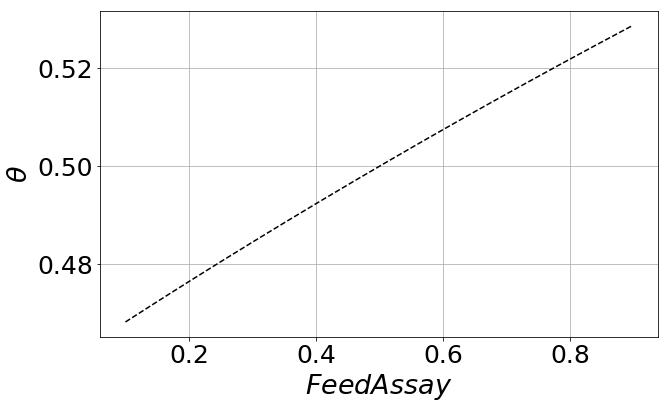

In [119]:
pylab.rcParams['figure.figsize'] = (10, 6)
t = np.arange(0.1, 0.9, 0.001)
y = [a_b_zero(v) for v in t]

plt.grid()
plt.plot(t, y, 'k--')
plt.ylabel(r'${\theta}$')
plt.xlabel(r'${Feed Assay}$')


#plt.legend()
#plt.savefig(filename="test.png")
plt.show()

In [ ]:
alpha_by_swu(0.5)

Populating the interactive namespace from numpy and matplotlib


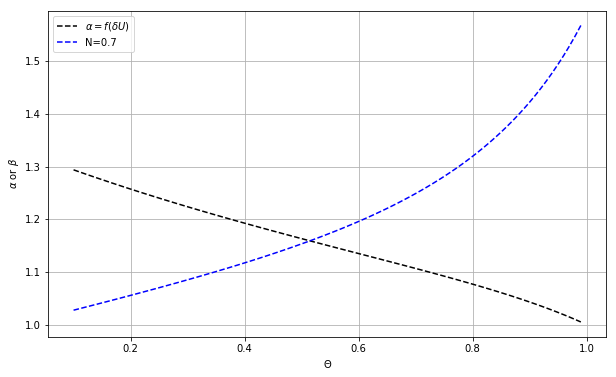

In [9]:
pylab.rcParams['figure.figsize'] = (10, 6)
t = np.arange(0.1, 1.0, 0.01)

plt.plot(t, alpha_by_swu(t), 'k--', label=r'${\alpha = f(\delta U)}$')
#plt.plot(t, beta_by_alpha(t, 0.02), 'r--', label='N=0.07')
plt.plot(t, beta_by_alpha(t, 0.7), 'b--', label='N=0.7')

plt.ylabel(r'${\alpha}$ or ${\beta}$')
plt.xlabel(r'${\Theta}$')
plt.grid()



plt.legend()

plt.savefig(filename="alpha_vs_beta.png")



plt.show()

In [11]:
pylab.rcParams['figure.figsize'] = (10, 6)
t = np.arange(0.40, 0.55, 0.0001)

plt.grid()
plt.plot(t, alpha_by_swu(t)-beta_by_alpha(t, N), 'k--', label='N=0.700')
plt.plot(t, alpha_by_swu(t)-beta_by_alpha(t, 0.200), 'g--', label='N=0.200')
plt.plot(t, alpha_by_swu(t)-beta_by_alpha(t, 0.035), 'r--', label='N=0.035')
plt.plot(t, alpha_by_swu(t)-beta_by_alpha(t, 0.007), 'b--', label='N=0.007')
#plt.plot(t, alpha_by_swu(t)-beta_by_alpha(t, 0.003), 'g--', label='N=0.003')
plt.axhline(y=0.0, xmin=0, xmax = 1, linewidth=2, color='k')
plt.ylabel(r'${\alpha-\beta}$')
plt.xlabel(r'${\Theta}$')
plt.legend()
plt.savefig(filename="alpha_minus_beta.png")
plt.show()

SyntaxError: keyword can't be an expression (<ipython-input-11-76aedbff2fcd>, line 23)

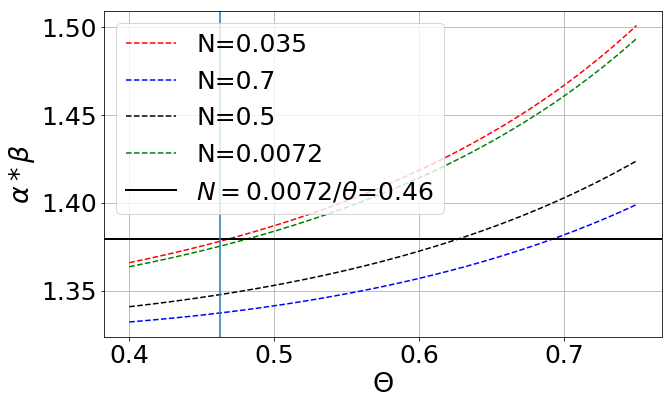

In [90]:
pylab.rcParams['figure.figsize'] = (10, 6)
t = np.arange(0.4, 0.75, 0.0001)

plt.grid()
plt.plot(t, alpha_by_swu(t)*beta_by_alpha(t, 0.035), 'r--', label='N=0.035')
plt.plot(t, alpha_by_swu(t)*beta_by_alpha(t, 0.7), 'b--', label='N=0.7')

plt.plot(t, alpha_by_swu(t)*beta_by_alpha(t, 0.5), 'k--', label='N=0.5')

plt.plot(t, alpha_by_swu(t)*beta_by_alpha(t, 0.072), 'g--', label='N=0.0072')
plt.axhline(y=alpha_by_swu(0.46)*beta_by_alpha(0.46, 0.0072), xmin=0, xmax = 1, linewidth=2, color='k', label=r'$N=0.0072/\theta $=0.46')
plt.axvline(x=0.4627894390421519)
plt.ylabel(r'${\alpha*\beta}$')
plt.xlabel(r'${\Theta}$')


plt.legend()
plt.savefig(filename="alpha_times_beta.png")
plt.show()

In [12]:
def P_by_gamma_plus(gamma, F, theta):
    P = 1. / (2. * (gamma - 1.) * theta) 
    P *= (sqrt(pow((F-theta)*gamma,2) 
                  + (2*F+2*theta - 2*F*F - 2*theta*theta)*gamma 
                  + pow(F+theta -1, 2) )
             + (F+theta)*gamma - F - theta +1)
    return P

def P_by_gamma_minus(gamma, F, theta):
    P = 1. / (2. * (gamma - 1.) * theta) 
    P *= (-sqrt(pow((F-theta)*gamma,2) 
                  + (2.*F + 2.*theta - 2.*F*F - 2.*theta*theta)*gamma 
                  + pow(F + theta - 1., 2) ) 
             + (F + theta)*gamma - F - theta + 1.)
    return P

In [13]:

theta_ = 0.46040372309
print(alpha_by_swu(theta_))
print(beta_by_alpha(theta_, 0.007))

1.1746623368715323
1.1746623368719693


In [14]:
def leveling_by_gamma(gamma, F, theta, level):
    for i in range(level):
        F = P_by_gamma_minus(gamma, F, theta)
    return F

In [15]:
alpha_ = alpha_by_swu(theta_)
F = 0.007
R_P = F/(1-F)*alpha_
P = R_P/(1+R_P)
print(P)

0.008212595340443132


In [16]:
gamma_ = 1.1746623368715323*1.1746623368719693
print("gamma", gamma_)
theta_ = 0.46040372309
print("1 level: ", P_by_gamma_minus(gamma_, 0.007, theta_))
print("10 level: ", leveling_by_gamma(gamma_, 0.007, theta_, 11))



gamma 1.3798316056650026
1 level:  0.008212595340443064
10 level:  0.03988598004371069


Populating the interactive namespace from numpy and matplotlib


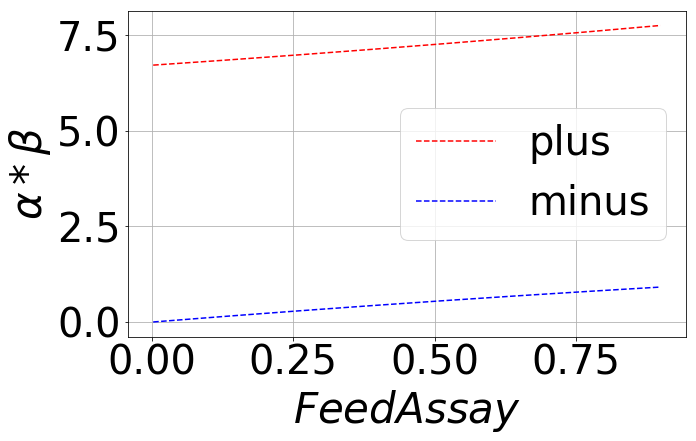

In [17]:
pylab.rcParams['figure.figsize'] = (10, 6)
t = np.arange(0.002, 0.9, 0.00001)

plt.grid()
plt.plot(t, P_by_gamma_plus(gamma_, t, theta_), 'r--', label='plus')
plt.plot(t, P_by_gamma_minus(gamma_, t, theta_), 'b--', label='minus')


plt.ylabel(r'${\alpha*\beta}$')
plt.xlabel(r'${Feed Assay}$')


plt.legend()
plt.savefig(filename="alpha_times_beta.png")
plt.show()

Populating the interactive namespace from numpy and matplotlib


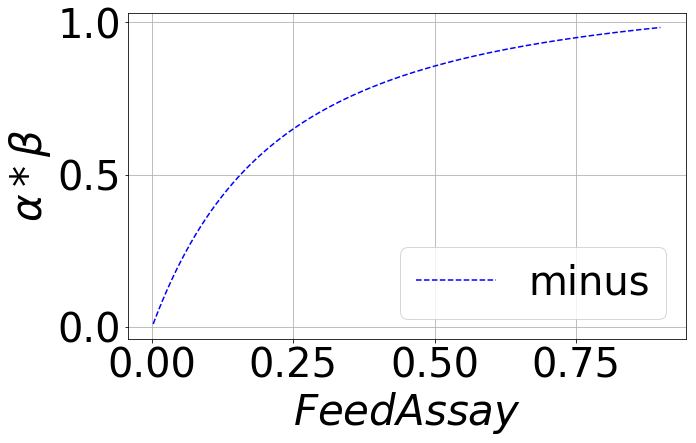

In [18]:
pylab.rcParams['figure.figsize'] = (10, 6)
t = np.arange(0.002, 0.9, 0.00001)

plt.grid()
#plt.plot(t, P_by_gamma_plus(gamma_, t, theta_), 'r--', label='plus')
plt.plot(t, leveling_by_gamma(gamma_, t, theta_, 10), 'b--', label='minus')


plt.ylabel(r'${\alpha*\beta}$')
plt.xlabel(r'${Feed Assay}$')


plt.legend()
plt.savefig(filename="alpha_times_beta.png")
plt.show()